In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import h5py
from scripts.sample_db import SampleDB

def compute_correlation_matrix(traces, window_size):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrix = np.zeros((num_traces, num_traces))
    
    for i in range(num_traces):
        for j in range(i, num_traces):
            correlations = []
            for k in range(num_windows):
                window_i = traces[i, k:k+window_size]
                window_j = traces[j, k:k+window_size]
                corr, _ = pearsonr(window_i, window_j)
                correlations.append(corr)
            
            avg_correlation = np.mean(correlations)
            correlation_matrix[i, j] = avg_correlation
            correlation_matrix[j, i] = avg_correlation
    
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, odors, trials, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)
    
    # Add odor and trial labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(odors)) + 0.5)
    ax.set_yticks(np.arange(len(odors)) + 0.5)
    ax.set_xticklabels([f'Odor {o}\nTrial {t}' for o, t in zip(odors, trials)], rotation=45, ha='right')
    ax.set_yticklabels([f'Odor {o}\nTrial {t}' for o, t in zip(odors, trials)], rotation=0)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load the sample database
    db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
    sample_db = SampleDB()
    sample_db.load(db_path)

    # Loading experiment
    sample_id = '20220426_RM0008_130hpf_fP1_f3'  
    exp = sample_db.get_sample(sample_id)
    print(exp.sample.id)

20220426_RM0008_130hpf_fP1_f3


In [4]:

    # Path to the HDF5 file
    hdf5_file_path = f'{exp.paths.trials_path}/traces/{exp.sample.id}_fluorescence_data.h5'

    # Load data from HDF5 file
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[exp.sample.id]
        print(exp_grp.keys())
        traces = exp_grp['dff_traces'][()]  # Use dF/F traces
        odors = exp_grp['odor'][()]
        trials = exp_grp['trial_nr'][()]

<KeysViewHDF5 ['cell_mapping', 'dff_traces', 'lm_plane_centroids', 'lm_plane_labels', 'odor', 'plane_nr', 'raw_traces', 'trial_nr']>


In [11]:

    # Sort traces by odor and trial
    sort_indices = np.lexsort((trials, odors))
    print(sort_indices)
    traces = traces[sort_indices]
    print(traces[:10])
    odors = odors[sort_indices]
    print(odors[:10])
    trials = trials[sort_indices]
    print(trials[:10])

[    0     1     2 ... 52628 52629 52630]
[[ 1.1610324e-03 -1.3413973e-03 -1.3914388e-03 ...  9.2846580e-04
   9.7496714e-04  1.1619324e-03]
 [-1.1013461e-04 -1.5393052e-03 -1.6417017e-03 ...  5.9080386e-04
   1.5879540e-03  6.7064544e-04]
 [ 1.3008186e-03 -1.3075984e-03 -1.4139751e-03 ...  1.5041522e-04
  -3.2542966e-04  9.8456876e-05]
 ...
 [ 4.4400729e-03 -1.1137534e-03 -1.4093822e-03 ... -8.3402498e-05
   1.5630468e-04  3.2046961e-04]
 [-4.4218841e-04 -1.8254891e-03 -1.8342453e-03 ...  2.5488957e-04
   7.4349786e-04  6.3104660e-04]
 [-2.4680898e-04 -1.2737695e-03 -1.2737695e-03 ...  9.2170820e-05
  -3.5248138e-04 -2.1362508e-05]]
[b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala']
[b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1']


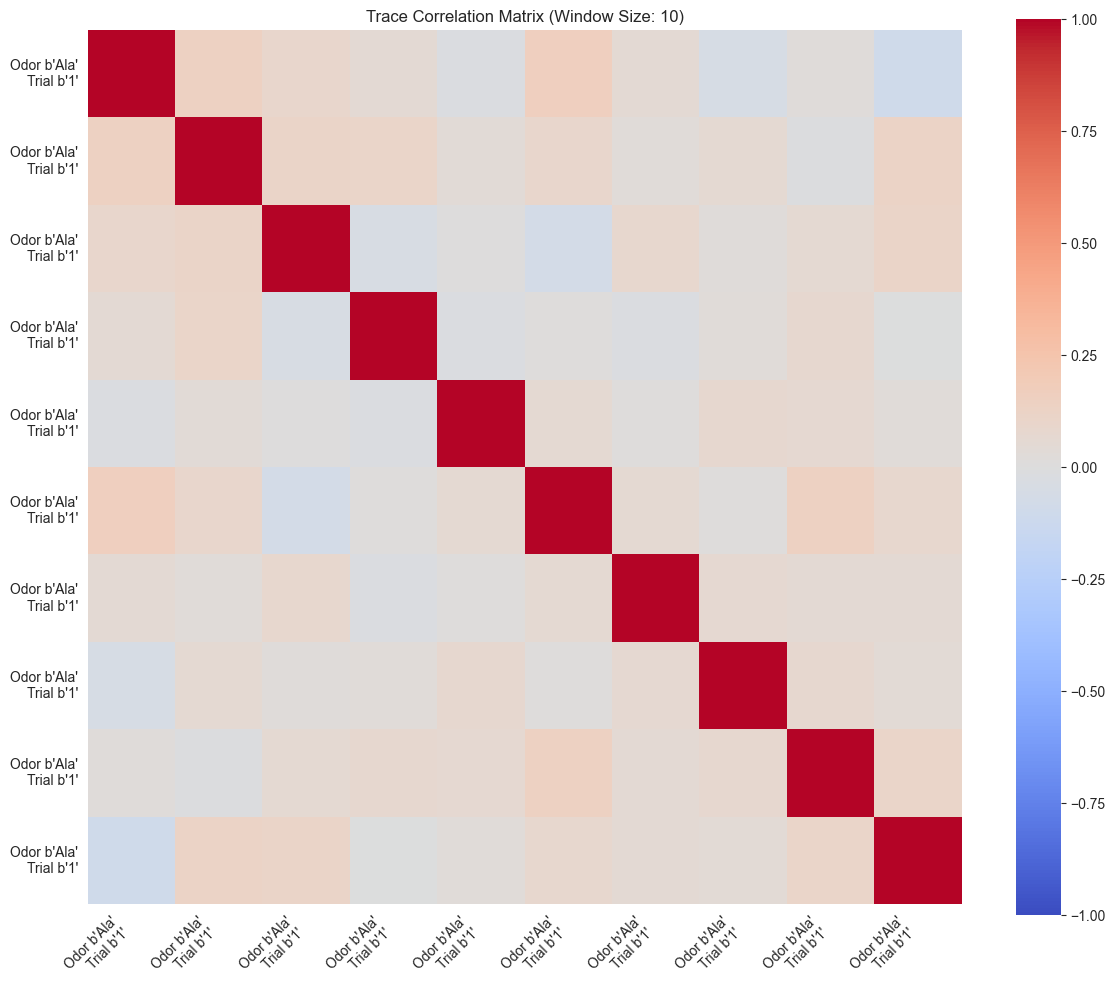

In [12]:

    # User input for window size
    window_size = int(input("Enter the window size (frames) for correlation calculation: "))

    # Compute correlation matrix
    correlation_matrix = compute_correlation_matrix(traces[:10], window_size)

    # Plot correlation matrix
    plot_correlation_matrix(correlation_matrix, odors[:10], trials[:10], f"Trace Correlation Matrix (Window Size: {window_size})")

20220426_RM0008_130hpf_fP1_f3
<KeysViewHDF5 ['cell_mapping', 'dff_traces', 'lm_plane_centroids', 'lm_plane_labels', 'odor', 'plane_nr', 'raw_traces', 'trial_nr']>


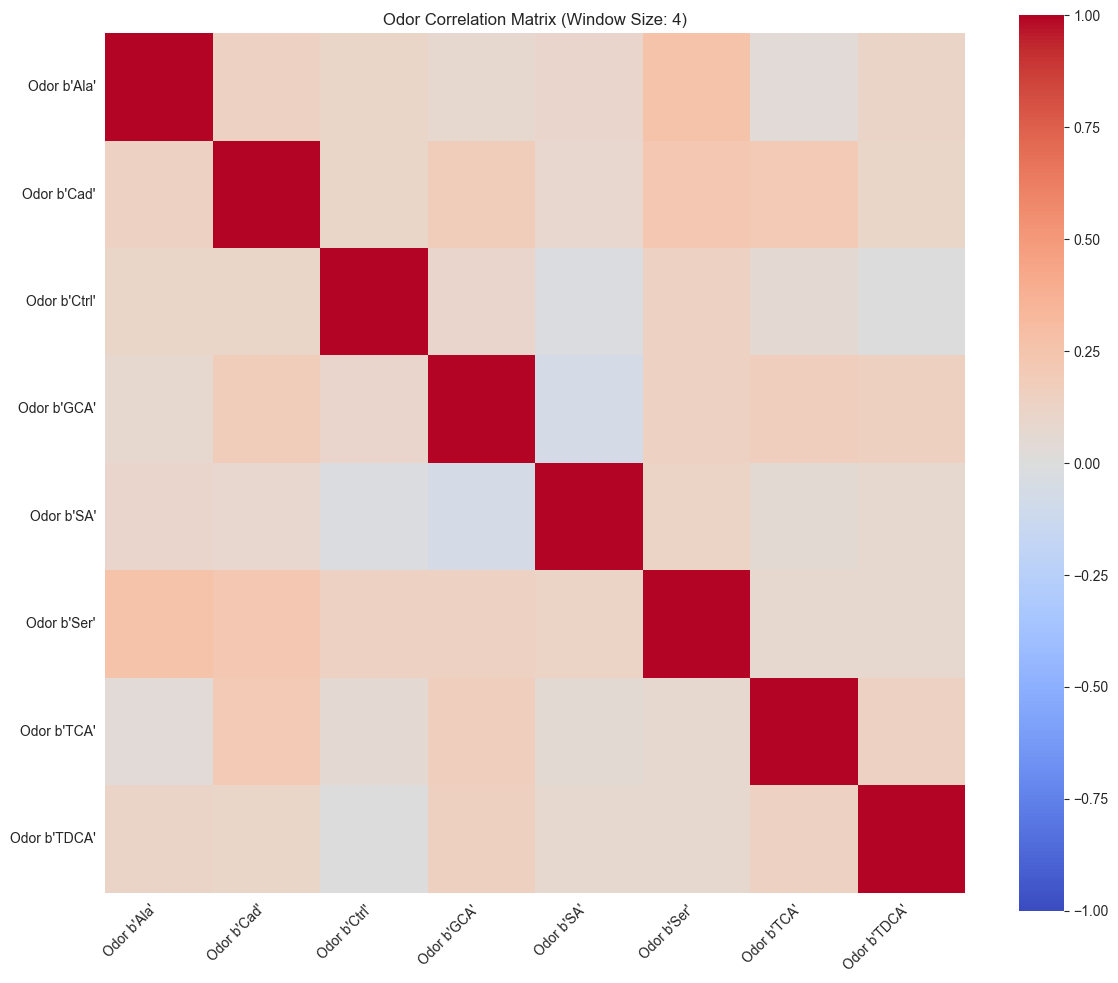

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import h5py
from scripts.sample_db import SampleDB

import h5py
import numpy as np

def average_traces(traces, odors, trials, average_by='odor_trial'):
    unique_combinations = []
    averaged_traces = []
    averaged_labels = []
    
    if average_by == 'odor':
        unique_combinations = np.unique(odors)
    elif average_by == 'trial':
        unique_combinations = np.unique(trials)
    elif average_by == 'odor_trial':
        unique_combinations = np.unique(list(zip(odors, trials)), axis=0)
    else:
        raise ValueError("average_by must be 'odor', 'trial', or 'odor_trial'")
    
    for combo in unique_combinations:
        if average_by == 'odor':
            mask = odors == combo
            label = f"{combo}"
        elif average_by == 'trial':
            mask = trials == combo
            label = f"t{combo}"
        else:  # odor_trial
            odor, trial = combo
            mask = (odors == odor) & (trials == trial)
            label = f"{odor}_t{trial}"
        
        avg_trace = np.mean(traces[mask], axis=0)
        averaged_traces.append(avg_trace)
        averaged_labels.append(label)
    
    return np.array(averaged_traces), np.array(averaged_labels)

def compute_correlation_matrix(traces, window_size):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrix = np.zeros((num_traces, num_traces))
    
    for i in range(num_traces):
        for j in range(i, num_traces):
            correlations = []
            for k in range(num_windows):
                window_i = traces[i, k:k+window_size]
                window_j = traces[j, k:k+window_size]
                corr, _ = pearsonr(window_i, window_j)
                correlations.append(corr)
            
            avg_correlation = np.mean(correlations)
            correlation_matrix[i, j] = avg_correlation
            correlation_matrix[j, i] = avg_correlation
    
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, odors, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)
    
    # Add odor labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(odors)) + 0.5)
    ax.set_yticks(np.arange(len(odors)) + 0.5)
    ax.set_xticklabels([f'Odor {o}' for o in odors], rotation=45, ha='right')
    ax.set_yticklabels([f'Odor {o}' for o in odors], rotation=0)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load the sample database
    db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
    sample_db = SampleDB()
    sample_db.load(db_path)

    # Loading experiment
    sample_id = '20220426_RM0008_130hpf_fP1_f3'  
    exp = sample_db.get_sample(sample_id)
    print(exp.sample.id)

    # Path to the HDF5 file
    hdf5_file_path = f'{exp.paths.trials_path}/traces/{exp.sample.id}_fluorescence_data.h5'

    # Load data from HDF5 file
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[exp.sample.id]
        print(exp_grp.keys())
        traces = exp_grp['dff_traces'][()]  # Use dF/F traces
        odors = exp_grp['odor'][()]
        trials = exp_grp['trial_nr'][()]

    # Average traces over trials for each odor
    averaged_traces, averaged_odors = average_over_trials(traces, odors, trials)

    # User input for window size
    window_size = int(input("Enter the window size for correlation calculation: "))

    # Compute correlation matrix
    correlation_matrix = compute_correlation_matrix(averaged_traces, window_size)

    # Plot correlation matrix
    plot_correlation_matrix(correlation_matrix, averaged_odors, f"Odor Correlation Matrix (Window Size: {window_size})")